# 3. Exploratory Data Analysis (EDA)

**Objective:** Identify the primary drivers of default (`TARGET = 1`) and validate business hypotheses, confirming whether the variables processed and engineered in the previous stage carry real predictive signal.

**Context (CRISP-DM):** With clean and enriched data (*Data Preparation*), we move into the **Hypothesis Validation** phase. Within the CRISP-DM cycle, this stage acts as a filter between preparation and modeling: we must ensure that our variables clearly distinguish the behavior of good payers from those who default.

**Analysis Strategy:** We will utilize a hybrid "Focus & Scan" approach:
* **Focus (Business Hypotheses):** In-depth analysis of high-impact variables to answer direct business questions.
* **Scan (Profile Sweep):** Grid visualization of secondary variables to ensure no peripheral patterns are overlooked.

**Notebook Steps:**

1. **Baseline Definition (Target):** Calculation of the Global Average Default Rate.
2. **Key Hypothesis Testing (Focus):**
    * *H1 - Maturity:* Does age influence repayment behavior?
    * *H2 - Capacity:* Is the income commitment ratio (`DEBT_TO_INCOME`) a decisive factor?
    * *H3 - Stability:* Does transparency in professional status change the risk profile?
    * *H4 - Social:* Is education a discriminating factor?
    * *H5 - History:* Do external scores (`EXT_SOURCE`) effectively predict risk?
3. **Secondary Profile Analysis (Scan):** Demographic and asset-based sweep.
4. **Multivariate Correlations:** Importance ranking of numerical variables.

## 3.1 Library Import & Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Show all columns when displaying a DataFrame
pd.set_option('display.max_columns', None)

sns.set_style('darkgrid')

### 3.1.1 Load Cleaned Dataset

In [3]:
df = pd.read_csv('../data/processed/application_train_cleaned.csv')

## 3.2 Baseline Definition (Target)

To contextualize all subsequent analyses, we must first establish the dataset's **Global Average Default Rate**.

* **Why is this important?** When analyzing specific segments (e.g., "Clients with Higher Education"), we will benchmark that group's rate against this global average.
* **The Rule:** If a segment exhibits a default rate significantly higher than the global average, it is classified as a **High-Risk Segment**.

In [4]:
# 1. Calculating the overall default rate
GLOBAL_DEFAULT_RATE = df['TARGET'].mean()

# 2. Displaying the Baseline for reference
print(f'--- Defined Baseline ---')
print(f'Global Default Rate (Medium Risk): {GLOBAL_DEFAULT_RATE:.2%}')
print(f'-------------------------')

# We'll use the variable ‘GLOBAL_DEFAULT_RATE’ to draw red lines in the next graphs.

--- Defined Baseline ---
Global Default Rate (Medium Risk): 8.07%
-------------------------


## 3.3 Key Hypothesis Validation (Focus)

In this stage, we will focus on variables with the highest theoretical impact on the business. We will use a **Dashed Red Line** to represent the Global Average Default Rate calculated previously (`GLOBAL_DEFAULT_RATE`).

* **Bars above the line:** Indicate **High-Risk** groups.
* **Bars below the line:** Indicate **Low-Risk** groups.

### H1: Maturity and Age
**Hypothesis:** Younger clients tend to be less financially stable and, therefore, present a higher risk of default.

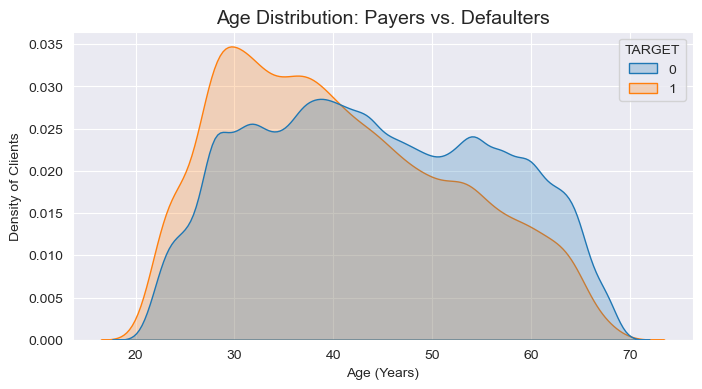

In [5]:
plt.figure(figsize=(8, 4))

# KDE Plot to see the age distribution separated by Target
sns.kdeplot(data=df, x='AGE', hue='TARGET', common_norm=False, fill=True)

plt.title('Age Distribution: Payers vs. Defaulters', fontsize=14)
plt.xlabel('Age (Years)')
plt.ylabel('Density of Clients');

### H2: Repayment Capacity (Debt-to-Income)
**Hypothesis:** Clients who commit a larger share of their income to loan installments (high `DEBT_TO_INCOME`) face greater difficulty in honoring their payments.

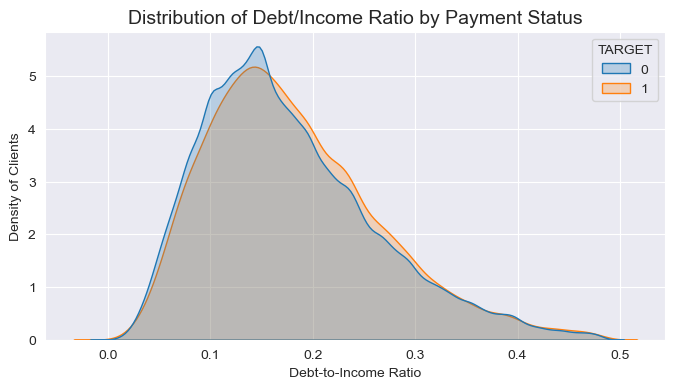

In [6]:
plt.figure(figsize=(8, 4))

# Limiting extreme outliers for visualization (focusing on the 99th percentile)
limit_dti = df['DEBT_TO_INCOME_RATIO'].quantile(0.99)
df_filtered = df[df['DEBT_TO_INCOME_RATIO'] < limit_dti]

sns.kdeplot(data=df_filtered, x='DEBT_TO_INCOME_RATIO', hue='TARGET', common_norm=False, fill=True)

plt.title('Distribution of Debt/Income Ratio by Payment Status', fontsize=14)
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Density of Clients');

### H3: Professional Stability (Occupation Type)
**Hypothesis:** The `Unknown` category (clients who are employed but did not report their occupation) presents a higher risk than the `Not Applicable` category (Pensioners/Unemployed).

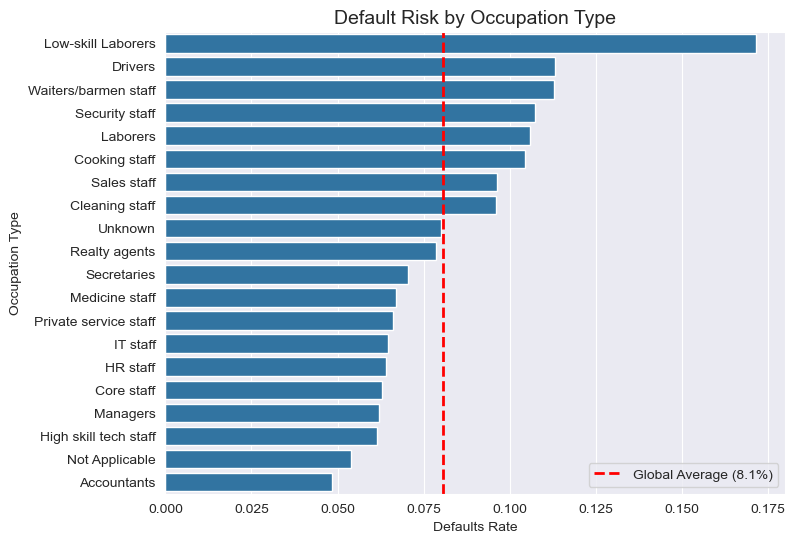

In [7]:
# Preparing the data: Calculating the average default rate by occupation
occ_risk = df.groupby('OCCUPATION_TYPE')['TARGET'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 6))

# Barplot
sns.barplot(x='TARGET', y='OCCUPATION_TYPE', data=occ_risk)

# Reference Line (Global Average)
plt.axvline(GLOBAL_DEFAULT_RATE, color='red', linestyle='--', linewidth=2, label=f'Global Average ({GLOBAL_DEFAULT_RATE:.1%})')

plt.title('Default Risk by Occupation Type', fontsize=14)
plt.xlabel('Defaults Rate')
plt.ylabel('Occupation Type')
plt.legend();

### H4: Social Profile (Education)
**Hypothesis:** Clients with higher educational attainment tend to possess greater financial stability and a lower risk of default.

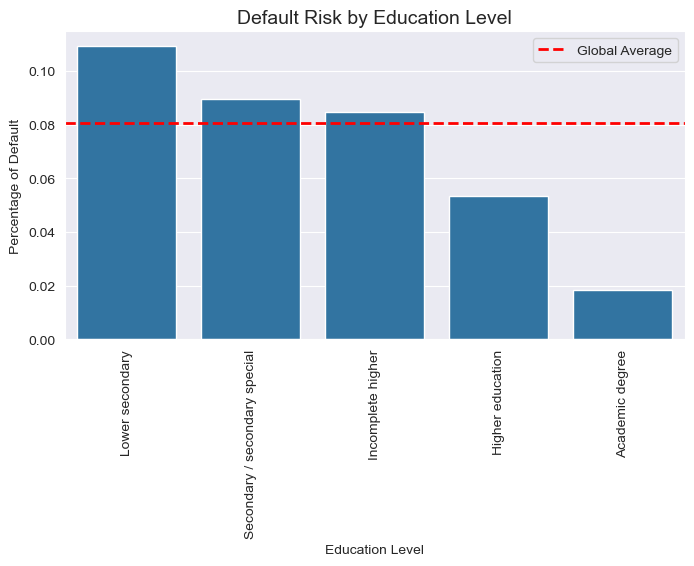

In [8]:
# Preparing the data: Calculating the average default rate by education level
edu_risk = df.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 4))

sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET', data=edu_risk)

# Reference Line (Global Average)
plt.axhline(GLOBAL_DEFAULT_RATE, color='r', linestyle='--', linewidth=2, label='Global Average')
plt.tick_params(axis='x', rotation=90)

plt.title('Default Risk by Education Level', fontsize=14)
plt.xlabel('Education Level')
plt.ylabel('Percentage of Default')
plt.legend();

### H5: Combined Credit History (External Sources Mean)
**Hypothesis:** The average of external scores (credit bureaus) is a strong predictor of default. A client's history with other financial institutions is a powerful indicator of their commitment to repayment. Clients with a low average score represent extreme risk.

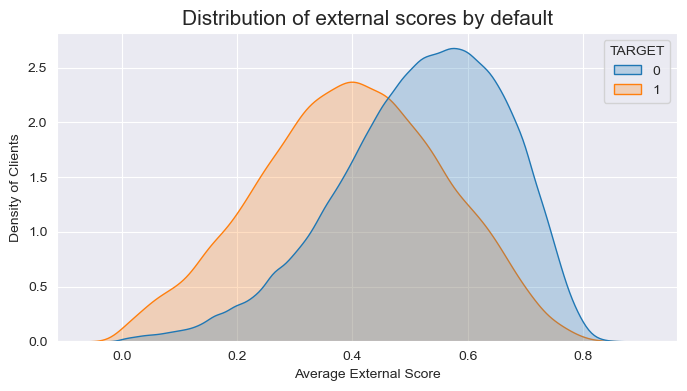

In [9]:
# Creating a new feature: Average of the three external scores
cols_source = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df['EXT_SOURCE_MEAN'] = df[cols_source].mean(axis=1)

plt.figure(figsize=(8, 4))

sns.kdeplot(data=df, x='EXT_SOURCE_MEAN', hue='TARGET', fill=True, common_norm=False)

plt.title('Distribution of external scores by default', fontsize=15)
plt.xlabel('Average External Score')
plt.ylabel('Density of Clients');

### 3.3.1 Hypothesis Validation Summary

Following the visual analysis of the key variables, we have consolidated the following insights for the modeling phase:

| Hypothesis | Variable(s) | Status | Business Insight |
| :--- | :--- | :--- | :--- |
| **H1: Maturity** | `AGE` | **Confirmed** | Younger clients (20-30 years) carry significantly higher risk. The risk curve decreases as age increases. |
| **H2: Capacity** | `DEBT_TO_INCOME` | **Rejected** | Income commitment did not show a clear separation between payers and defaulters. Low standalone predictive power. |
| **H3: Stability** | `OCCUPATION_TYPE` | **Partial** | The `Unknown` category presents moderate risk, but low-skill occupations (Laborers) are the highest risk. |
| **H4: Social** | `NAME_EDUCATION_TYPE` | **Confirmed** | Strong negative correlation: Higher education drastically reduces the likelihood of default. |
| **H5: History** | `EXT_SOURCE_MEAN` | **Strong** | **Best Predictor.** Low external scores are deterministic for default. The separation between classes is distinct. |

> **Strategic Decision:** We will prioritize Credit History (`EXT_SOURCE`) and Demographic variables (`AGE`, `EDUCATION`) during the modeling stage.

## 3.4 Demographic Profile Analysis (Scan)

We will perform a quick sweep of the secondary categorical variables to ensure no obvious patterns or hidden biases have been overlooked.

### 3.4.1 Utilities

In [10]:
def plot_risk(feature, label_rotation=False):
    # Create a DataFrame for plotting the quantity of clients in each category
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({
        feature: temp.index,
        'Number of Clients': temp.values
    })

    # Calculate the percentage of target=1 for each category
    cat_perc = df.groupby(feature)['TARGET'].mean().sort_values(ascending=False).reset_index()
    
    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

    # Chart 1: Number of Clients by Category
    sns.barplot(x=temp.index, y='Number of Clients', data=df1, ax=axes[0], errorbar=None, order=temp.index)
    axes[0].set_title(f'Number of Clients by {feature}', fontsize=12)
    axes[0].set_ylabel('Number of Clients')

    # Chart 2: Risk (Mean of Target) by Category
    sns.barplot(x=cat_perc[feature], y='TARGET', data=cat_perc, ax=axes[1], errorbar=None, order=cat_perc[feature])
    axes[1].set_title(f'Risk by {feature}', fontsize=12)
    axes[1].set_ylabel('Risk (Mean of Target)')
    axes[1].axhline(GLOBAL_DEFAULT_RATE, color='red', linestyle='--', label='Global Average', linewidth=2)

    if label_rotation:
        axes[0].tick_params(axis='x', rotation=90)
        axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout(pad=2.0)
    plt.show()

### 3.4.2 Categorical Variables

We will perform a quick scan of the categorical variables to ensure that no obvious patterns or hidden trends have been overlooked.

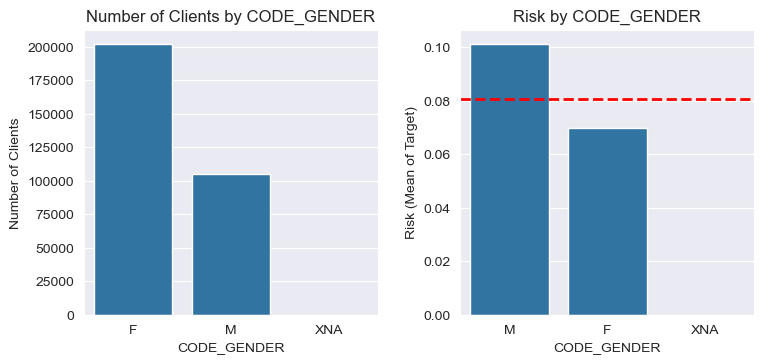

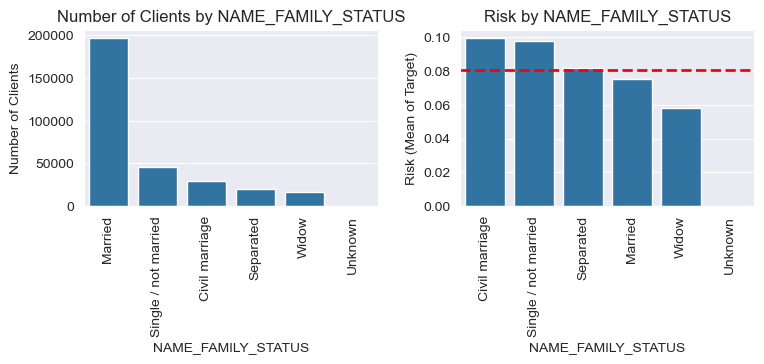

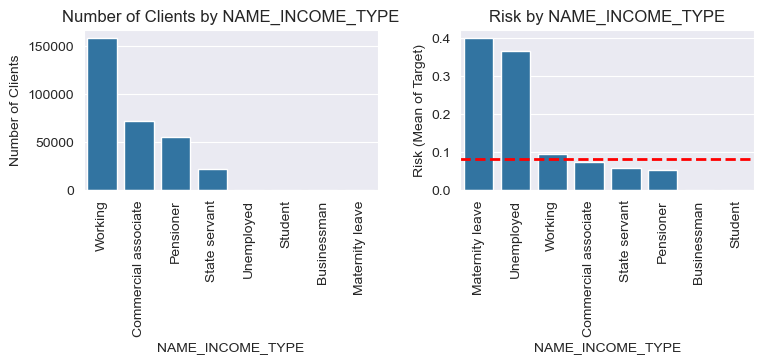

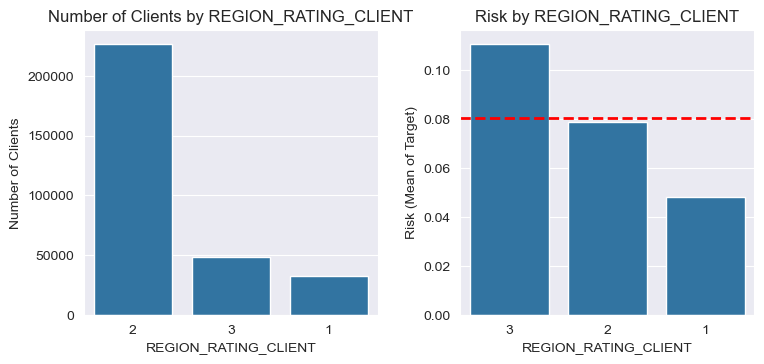

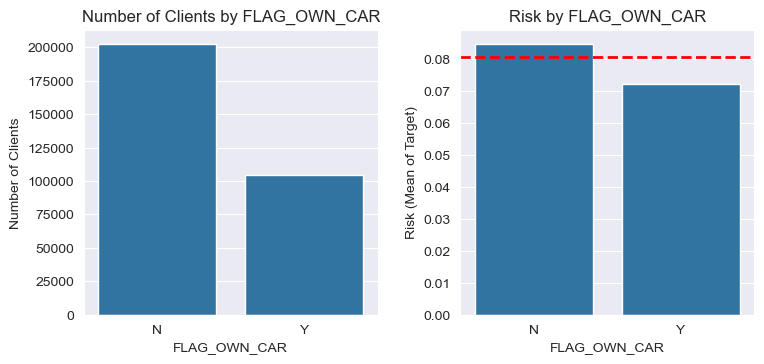

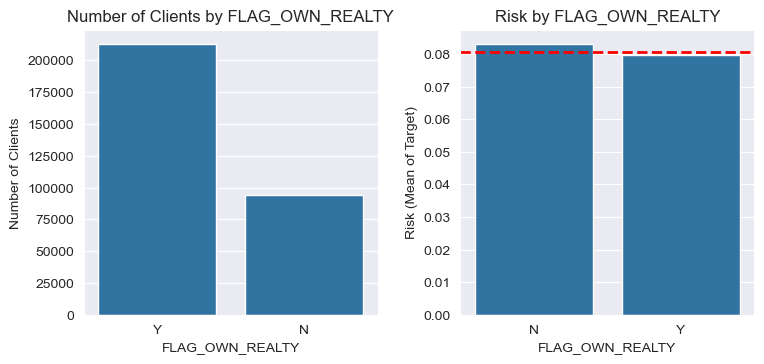

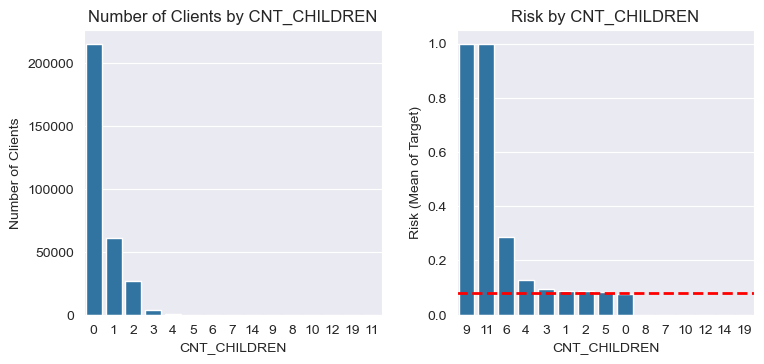

In [11]:
plot_risk('CODE_GENDER')
plot_risk('NAME_FAMILY_STATUS', label_rotation=True)
plot_risk('NAME_INCOME_TYPE', label_rotation=True)
plot_risk('REGION_RATING_CLIENT')
plot_risk('FLAG_OWN_CAR')
plot_risk('FLAG_OWN_REALTY')
plot_risk('CNT_CHILDREN')

### Conclusions:
* **`CODE_GENDER`**: Men, on average, exhibit higher default rates than women (even with a smaller sample size for males, the percentage of `TARGET = 1` remains higher).
* **`NAME_FAMILY_STATUS`**: The highest default rates are found among those with 'Civil marriage' status, followed by 'Single / not married' and 'Separated'.
* **`NAME_INCOME_TYPE`**: Unemployed individuals and those on maternity leave show significantly higher default rates.
* **`REGION_RATING_CLIENT`**: Clients from 'Region 3' present a substantially higher default rate (suggesting that Region 3 may be a more socio-economically vulnerable area).
* **`FLAG_OWN_CAR`**: Clients who do not own a car have, on average, a higher default rate.
* **`FLAG_OWN_REALTY`**: Clients who do not own property show a default rate slightly above the global average.
* **`CNT_CHILDREN`**: The majority of the data consists of individuals without children (who tend to be reliable payers). However, starting from 3-4 children, the default rate rises above average, reaching extreme levels for clients with 9 or 11 children.

## 3.5 Correlations with Target (Importance Ranking)

Finally, we will examine the **linear strength of numerical variables in relation to the target variable (`TARGET`)**.

This analysis reveals which variables, in isolation, possess the strongest predictive signal to "pull" the risk profile up or down.

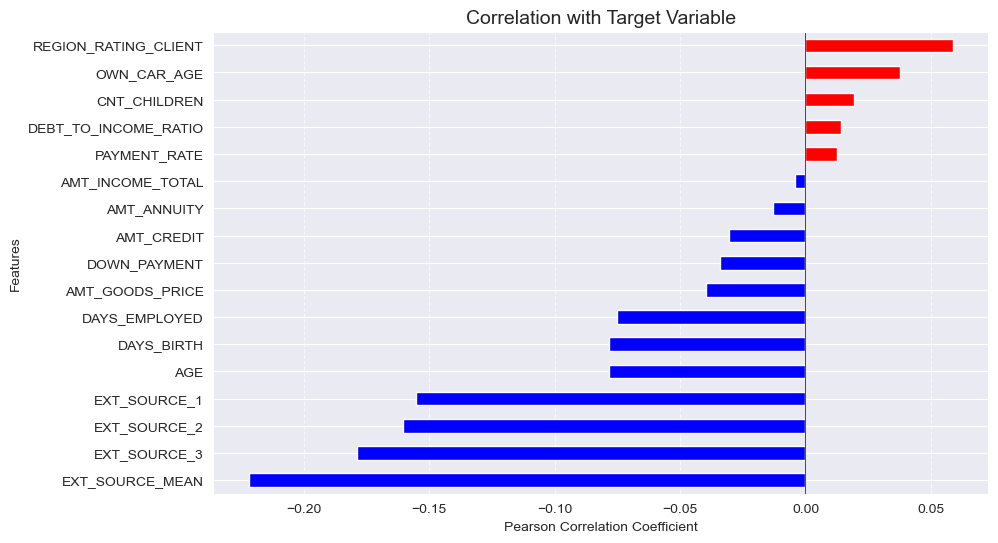

In [12]:
# Calculating correlations
correlations = df.corr(numeric_only=True)['TARGET'].sort_values()

correlations = correlations.drop(['TARGET', 'SK_ID_CURR'])

# Plotting the Ranking
plt.figure(figsize=(10, 6))

# Creating a color gradient: Red (High Risk) vs Blue (Protection)
# Positive Correlation (>0) = Increases chance of being 1 (Defaulter) -> Red
# Negative Correlation (<0) = Decreases chance of being 1 (Payer) -> Blue
colors = ['blue' if x < 0 else 'red' for x in correlations.values]

correlations.plot(kind='barh', color=colors)

plt.title('Correlation with Target Variable', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.savefig('../img/correlation_ranking.png', bbox_inches='tight')

The chart above provides the "treasure map" for our predictive modeling phase:

1. **(`EXT_SOURCE_MEAN`):** The longest red bar confirms that the average external score is, by far, the strongest indicator of creditworthiness (Negative Correlation: High Score = Low Risk).
2. **Risk Factors (`REGION_RATING`):** On the blue side, the client's region rating stands out as the primary positive indicator of risk.
3. **Feature Engineering Validation:**
    * **`AGE`:** Confirmed as a strong protective factor (older clients demonstrate better repayment behavior).
    * **`DEBT_TO_INCOME`:** Appears on the positive (blue) side, confirming that higher income commitment increases risk, although its relative strength is lower than that of behavioral history.

## 3.6 Conclusion & Next Steps

The Exploratory Data Analysis (EDA) has fulfilled its objective: validating data quality and testing business hypotheses prior to the modeling phase.

### Key Business Insights
1. **History Outperforms Capacity:** The client's historical behavior (represented by `EXT_SOURCE` and `AGE`) is a much stronger risk predictor than current financial capacity (`INCOME`, `DEBT_TO_INCOME`).
2. **The Low-Risk Profile:** The ideal client is older, holds a higher education degree, possesses high external credit scores, and shows job stability (years employed).
3. **The High-Risk Profile:** Young individuals (< 30 years old), working in low-skill or undisclosed (`Unknown`) occupations, and residing in regions with low commercial ratings.

### Impact on Modeling Strategy
Based on these findings, we have defined the strategy for the next stage (Machine Learning):
* **Feature Selection:** We will prioritize `EXT_SOURCE_MEAN`, `AGE`, `DAYS_EMPLOYED`, and `EDUCATION`.
* **Validated Feature Engineering:** The engineered variables `EXT_SOURCE_MEAN` and `AGE` proved their value and will be retained. `DEBT_TO_INCOME` will be kept as a secondary feature.
* **Model Expectation:** We expect tree-based models (such as Random Forest or XGBoost) to effectively capture the non-linear relationships identified in age and external scores.

---
**Project Status:** Dataset validated and ready for Modeling.